# Load Data

In [ ]:
! pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 15.4 MB/s 
     |████████████████████████████████| 132 kB 58.7 MB/s 
     |████████████████████████████████| 9.8 MB 51.5 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 140 kB 62.3 MB/s 
     |████████████████████████████████| 127 kB 72.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/data/gweb_sancl"
answer_dir = os.path.join(data_dir, "pos_fine", "answers")
wsj_dir = os.path.join(data_dir, "pos_fine", "wsj")
labeled_dir = os.path.join(data_dir, "unlabeled")

model_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/model"

In [ ]:
import codecs

In [ ]:
def read_conll_file(file_name, raw=False):
    """
    read in conll file
    word1    tag1
    ...      ...
    wordN    tagN
    Sentences MUST be separated by newlines!
    :param file_name: file to read in
    :param raw: if raw text file (with one sentence per line) -- adds 'DUMMY' label
    :return: generator of instances ((list of  words, list of tags) pairs)
    """
    current_words = []
    current_tags = []
    
    for line in codecs.open(file_name, encoding='utf-8'):
        #line = line.strip()
        line = line[:-1]

        if line:
            if raw:
                current_words = line.split() ## simple splitting by space
                current_tags = ['DUMMY' for _ in current_words]
                yield (current_words, current_tags)

            else:
                if len(line.split("\t")) != 2:
                    if len(line.split("\t")) == 1: # emtpy words in gimpel
                        raise IOError("Issue with input file - doesn't have a tag or token?")
                    else:
                        print("erroneous line: {} (line number: {}) ".format(line), file=sys.stderr)
                        exit()
                else:
                    word, tag = line.split('\t')
                current_words.append(word)
                current_tags.append(tag)

        else:
            if current_words and not raw: #skip emtpy lines
                yield (current_words, current_tags)
            current_words = []
            current_tags = []

    # check for last one
    if current_tags != [] and not raw:
        yield (current_words, current_tags)

In [ ]:
wsj_train_file = os.path.join(wsj_dir, "gweb-wsj-train.conll")
wsj_dev_file = os.path.join(wsj_dir, "gweb-wsj-dev.conll")

In [ ]:
wsj_train_word_lst = []
wsj_train_tag_lst = []
wsj_tags = []
for word, tag in read_conll_file(wsj_train_file):
  wsj_train_word_lst.append(word)
  wsj_train_tag_lst.append(tag)
  wsj_tags.extend(tag)
print("The number of sentences in wsj train", len(wsj_train_word_lst))

wsj_dev_word_lst = []
wsj_dev_tag_lst = []
for word, tag in read_conll_file(wsj_dev_file):
  wsj_dev_word_lst.append(word)
  wsj_dev_tag_lst.append(tag)
  wsj_tags.extend(tag)
print("The number of sentences in wsj dev", len(wsj_dev_word_lst))
print("The number of tags in wsj", len(set(wsj_tags)))

The number of sentences in wsj train 30060
The number of sentences in wsj dev 1336
The number of tags in wsj 48


In [ ]:
import random

In [ ]:
random.seed(0)
random.shuffle(wsj_train_word_lst)
random.seed(0)
random.shuffle(wsj_train_tag_lst)

In [ ]:
labeled_train_words = wsj_train_word_lst[:10000]
labeled_train_tags = wsj_train_tag_lst[:10000]
unlabeled_words = wsj_train_word_lst[10000:]
unlabeled_tags = wsj_train_tag_lst[10000:]

print(len(labeled_train_words))
print(len(unlabeled_words))

10000
20060


In [ ]:
wsj_tags = sorted(list(set(wsj_tags)))
wsj_tags = ["<pad>"] + wsj_tags
tag2idx = {tag:idx for idx, tag in enumerate(wsj_tags)}
idx2tag = {idx:tag for idx, tag in enumerate(wsj_tags)}
print(len(wsj_tags))

49


# Build Model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

100%|██████████| 213450/213450 [00:00<00:00, 843955.77B/s]


In [ ]:
class PosDataset(data.Dataset):
    def __init__(self, word_lst, tag_lst):
        sents, tags_li = [], [] # list of lists
        for i in range(len(word_lst)):
            sents.append(["[CLS]"] + word_lst[i] + ["[SEP]"])
            tags_li.append(["<pad>"] + tag_lst[i] + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


In [ ]:
def pad(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    is_heads = f(2)
    tags = f(3)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(1, maxlen)
    y = f(-2, maxlen)


    f = torch.LongTensor

    return words, f(x), is_heads, tags, f(y), seqlens

In [ ]:
from pytorch_pretrained_bert import BertModel

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size=None):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')

        self.fc = nn.Linear(768, vocab_size)
        self.device = device

    def forward(self, x, y):
        '''
        x: (N, T). int64
        y: (N, T). int64
        '''
        x = x.to(device)
        y = y.to(device)
        
        if self.training:
            self.bert.train()
            encoded_layers, _ = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x)
                enc = encoded_layers[-1]
        
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        _y = y # for monitoring
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))

In [ ]:
def eval(model, iterator):
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch

            _, _, y_hat = model(x, y)  # y_hat: (N, T)

            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    ## gets results and save
    with open("result", 'w') as fout:
        for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
            y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
            preds = [idx2tag[hat] for hat in y_hat]
            assert len(preds)==len(words.split())==len(tags.split())
            for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                fout.write("{} {} {}\n".format(w, t, p))
            fout.write("\n")
            
    ## calc metric
    y_true =  np.array([tag2idx[line.split()[1]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    y_pred =  np.array([tag2idx[line.split()[2]] for line in open('result', 'r').read().splitlines() if len(line) > 0])

    acc = (y_true==y_pred).astype(np.int32).sum() / len(y_true)

    print("accuracy", acc)
    print("classification_report", classification_report(y_true, y_pred))


In [ ]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [00:13<00:00, 29760412.11B/s]


In [ ]:
train_dataset = PosDataset(labeled_train_words, labeled_train_tags)
eval_dataset = PosDataset(wsj_dev_word_lst, wsj_dev_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
# train(model, train_iter, optimizer, criterion)
# eval(model, test_iter)

step: 0, loss: 3.9463701248168945
step: 10, loss: 2.018392324447632
step: 20, loss: 0.7985055446624756
step: 30, loss: 0.3254476487636566
step: 40, loss: 0.35109612345695496
step: 50, loss: 0.324329674243927
step: 60, loss: 0.22176219522953033
step: 70, loss: 0.15460249781608582
step: 80, loss: 0.14656797051429749
step: 90, loss: 0.16489265859127045
step: 100, loss: 0.1346680372953415
step: 110, loss: 0.08465590327978134
step: 120, loss: 0.10497339069843292
step: 130, loss: 0.10838736593723297
step: 140, loss: 0.05528959259390831
step: 150, loss: 0.149887353181839
step: 160, loss: 0.12817040085792542
step: 170, loss: 0.15120059251785278
step: 180, loss: 0.0764465257525444
step: 190, loss: 0.11801405251026154
step: 200, loss: 0.2753466069698334
step: 210, loss: 0.15532943606376648
step: 220, loss: 0.09293542057275772
step: 230, loss: 0.20889462530612946
step: 240, loss: 0.10068797320127487
step: 250, loss: 0.11133162677288055
step: 260, loss: 0.06397204846143723
step: 270, loss: 0.14717

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save Model

In [ ]:
model_file = os.path.join(model_dir, "model.pt")
# torch.save(model.state_dict(), model_file)

## Load Model

In [ ]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(model_file))
eval(model, test_iter)

accuracy 0.969618596534962
classification_report               precision    recall  f1-score   support

           1       0.99      1.00      1.00       125
           2       0.99      1.00      1.00       236
           3       1.00      1.00      1.00      1629
           4       0.67      1.00      0.80        53
           5       1.00      0.42      0.59        55
           6       1.00      1.00      1.00      1321
           7       0.96      0.99      0.98       187
           9       1.00      0.99      0.99       809
          10       1.00      1.00      1.00      1270
          11       1.00      0.99      0.99      2768
          12       1.00      1.00      1.00        29
          13       0.00      0.00      0.00         2
          14       0.99      0.96      0.98       409
          15       0.97      0.99      0.98      3419
          16       0.92      0.91      0.92      1819
          17       0.88      0.93      0.90       114
          18       0.99      0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Self Training

In [ ]:
unlabeled_dataset = PosDataset(unlabeled_words, unlabeled_tags)

unlabeled_iter = data.DataLoader(dataset=unlabeled_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

In [ ]:
model.eval()

Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
LLD = []
new_x_lst = []
new_y_lst = []
i = 0

with torch.no_grad():
    for i, batch in enumerate(unlabeled_iter):

      words, x, is_heads, tags, y, seqlens = batch

      logits, _, y_hat = model(x, y)  # y_hat: (N, T)

      # Save prediction as new training dataset
      softmax_value = torch.softmax(logits, dim=2)
      max_prob = torch.amax(softmax_value, dim=2)
      lld = torch.prod(max_prob, 1)
      LLD.extend(lld)

      new_x_lst.extend(x.tolist())
      new_y_lst.extend(y_hat.tolist())

      Words.extend(words)
      Is_heads.extend(is_heads)
      Tags.extend(tags)
      Y.extend(y.numpy().tolist())
      Y_hat.extend(y_hat.cpu().numpy().tolist())

In [ ]:
len(Words)

20060

In [ ]:
ind = list(range(len(LLD)))
ind = [x for _, x in sorted(zip(LLD, ind), reverse=True)]

select_ind = ind[: 2000]
not_select_ind = ind[2000:]

new_train_x = [new_x_lst[i] for i in select_ind]
new_train_y = [new_y_lst[i] for i in select_ind]

remain_train_x = [new_x_lst[i] for i in not_select_ind]
remain_train_y = [new_y_lst[i] for i in not_select_ind]

In [ ]:
top_sentences = [Words[s] for s in select_ind]

In [ ]:
top_sentences_set = set(top_sentences)

In [ ]:
len(top_sentences_set)

2000

In [ ]:
class PosDataset_new(data.Dataset):
    def __init__(self, word_lst, tag_lst):
        self.word_lst, self.tag_lst = word_lst, tag_lst

    def __len__(self):
      return len(self.word_lst)

    def __getitem__(self, idx):
      words, tags = self.word_lst[idx], self.tag_lst[idx] # words, tags: string list
      assert len(words)==len(tags)
        # seqlen
      seqlen = len(words)

      return words, tags, seqlen

def pad_new(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    tags = f(1)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(0, maxlen)
    y = f(1, maxlen)

    f = torch.LongTensor

    return f(x), f(y), seqlens

In [ ]:
new_train_dataset = PosDataset_new(new_train_x, new_train_y)

new_train_iter = data.DataLoader(dataset=new_train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad_new)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
def train_new(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        x, y, seqlens = batch
        
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))

In [ ]:
train_new(model, new_train_iter, optimizer, criterion)
eval(model, test_iter)

step: 0, loss: 0.13175822794437408
step: 10, loss: 0.06500213593244553
step: 20, loss: 0.04235837236046791
step: 30, loss: 0.06930667906999588
step: 40, loss: 0.049075935035943985
step: 50, loss: 0.05700163543224335
step: 60, loss: 0.03679328411817551
step: 70, loss: 0.06033544987440109
step: 80, loss: 0.054879385977983475
step: 90, loss: 0.05069451034069061
step: 100, loss: 0.06683169305324554
step: 110, loss: 0.07210827618837357
step: 120, loss: 0.09831839799880981
step: 130, loss: 0.06754110008478165
step: 140, loss: 0.09271911531686783
step: 150, loss: 0.050322026014328
step: 160, loss: 0.0321730300784111
step: 170, loss: 0.07775381952524185
step: 180, loss: 0.046156466007232666
step: 190, loss: 0.07832826673984528
step: 200, loss: 0.09453294426202774
step: 210, loss: 0.06591164320707321
step: 220, loss: 0.07453957945108414
step: 230, loss: 0.08637044578790665
step: 240, loss: 0.0495699904859066
accuracy 0.9687461049482737
classification_report               precision    recall  f1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.eval()

Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
LLD = []
new_x_lst = []
new_y_lst = []
i = 0

with torch.no_grad():
    for i, batch in enumerate(unlabeled_iter):

      words, x, is_heads, tags, y, seqlens = batch

      logits, _, y_hat = model(x, y)  # y_hat: (N, T)

      # Save prediction as new training dataset
      softmax_value = torch.softmax(logits, dim=2)
      max_prob = torch.amax(softmax_value, dim=2)
      lld = torch.prod(max_prob, 1)
      LLD.extend(lld)

      new_x_lst.extend(x.tolist())
      new_y_lst.extend(y_hat.tolist())

      Words.extend(words)
      Is_heads.extend(is_heads)
      Tags.extend(tags)
      Y.extend(y.numpy().tolist())
      Y_hat.extend(y_hat.cpu().numpy().tolist())

In [ ]:
ind = list(range(len(LLD)))
ind = [x for _, x in sorted(zip(LLD, ind), reverse=True)]

select_ind = ind[: 2000]
not_select_ind = ind[2000:]

new_train_x = [new_x_lst[i] for i in select_ind]
new_train_y = [new_y_lst[i] for i in select_ind]

In [ ]:
new_top_sentences = [Words[s] for s in select_ind]
new_top_sentences_set = set(new_top_sentences)

In [ ]:
# new_top_sentences - top_sentences
new_diff = new_top_sentences_set.difference(top_sentences_set)
# top_sentences - new_top_sentences
old_diff = top_sentences_set.difference(new_top_sentences_set)

In [ ]:
len(sentences_diff)

1739

In [ ]:
loop_i = 0
while len(new_top_sentences_set.difference(top_sentences_set)) <= 200:
  loop_i += 1
  print("\nLoop", loop_i)
  print("Remain dataset", len(remain_train_x))

  # Generate dataset 
  new_unlabeled_dataset = PosDataset_new(remain_train_x, remain_train_y)

  new_unlabeled_iter = data.DataLoader(dataset=new_unlabeled_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad_new)

  # Prediction
  model.eval()

  LLD = []
  new_x_lst = []
  new_y_lst = []
  i = 0

  with torch.no_grad():
      for i, batch in enumerate(new_unlabeled_iter):

        x, y, seqlens = batch

        logits, _, y_hat = model(x, y)  # y_hat: (N, T)

        # Save prediction as new training dataset
        softmax_value = torch.softmax(logits, dim=2)
        max_prob = torch.amax(softmax_value, dim=2)
        lld = torch.prod(max_prob, 1)
        LLD.extend(lld)

        new_x_lst.extend(x.tolist())
        new_y_lst.extend(y_hat.tolist())

  ind = list(range(len(LLD)))
  ind = [x for _, x in sorted(zip(LLD, ind), reverse=True)]
  select_ind = ind[: 2000]
  not_select_ind = ind[2000:]

  new_train_x = [new_x_lst[i] for i in select_ind]
  new_train_y = [new_y_lst[i] for i in select_ind]

  remain_train_x = [new_x_lst[i] for i in not_select_ind]
  remain_train_y = [new_y_lst[i] for i in not_select_ind]
  # train model
  optimizer = optim.Adam(model.parameters(), lr = 0.0001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train_new(model, new_train_iter, optimizer, criterion)


  eval(model, test_iter)


Loop 1
Remain dataset 18060
step: 0, loss: 0.03387511149048805
step: 10, loss: 0.08041409403085709
step: 20, loss: 0.07576928287744522
step: 30, loss: 0.03719585761427879
step: 40, loss: 0.03793807327747345
step: 50, loss: 0.05613357201218605
step: 60, loss: 0.0617285817861557
step: 70, loss: 0.09802041202783585
step: 80, loss: 0.047864172607660294
step: 90, loss: 0.09668195992708206
step: 100, loss: 0.0840291678905487
step: 110, loss: 0.04634398967027664
step: 120, loss: 0.03393184393644333
step: 130, loss: 0.041940852999687195
step: 140, loss: 0.02925848588347435
step: 150, loss: 0.06991099566221237
step: 160, loss: 0.043631669133901596
step: 170, loss: 0.05638584494590759
step: 180, loss: 0.05049470439553261
step: 190, loss: 0.05955478176474571
step: 200, loss: 0.06083463132381439
step: 210, loss: 0.0639224424958229
step: 220, loss: 0.03133399039506912
step: 230, loss: 0.04272076115012169
step: 240, loss: 0.08042771369218826
accuracy 0.9664402343263119
classification_report        

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.033802710473537445
step: 10, loss: 0.03264637291431427
step: 20, loss: 0.025558797642588615
step: 30, loss: 0.03916459158062935
step: 40, loss: 0.029730170965194702
step: 50, loss: 0.028933893889188766
step: 60, loss: 0.06623674184083939
step: 70, loss: 0.02319684997200966
step: 80, loss: 0.03547313064336777
step: 90, loss: 0.05208820477128029
step: 100, loss: 0.014772629365324974
step: 110, loss: 0.025128137320280075
step: 120, loss: 0.050528813153505325
step: 130, loss: 0.031239036470651627
step: 140, loss: 0.04336753115057945
step: 150, loss: 0.0375884473323822
step: 160, loss: 0.042078934609889984
step: 170, loss: 0.06188686564564705
step: 180, loss: 0.03733464330434799
step: 190, loss: 0.05363009124994278
step: 200, loss: 0.013346710242331028
step: 210, loss: 0.01733534038066864
step: 220, loss: 0.027978630736470222
step: 230, loss: 0.04664081335067749
step: 240, loss: 0.09549206495285034
accuracy 0.9689019070173251
classification_report               precision   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.07083073258399963
step: 10, loss: 0.012032496742904186
step: 20, loss: 0.025874201208353043
step: 30, loss: 0.009324867278337479
step: 40, loss: 0.012447481974959373
step: 50, loss: 0.020384514704346657
step: 60, loss: 0.045017410069704056
step: 70, loss: 0.05141768977046013
step: 80, loss: 0.05812250077724457
step: 90, loss: 0.04314720630645752
step: 100, loss: 0.01929996721446514
step: 110, loss: 0.021622737869620323
step: 120, loss: 0.03527675196528435
step: 130, loss: 0.03984002768993378
step: 140, loss: 0.031749576330184937
step: 150, loss: 0.03320395573973656
step: 160, loss: 0.007386897224932909
step: 170, loss: 0.02778368815779686
step: 180, loss: 0.04370421543717384
step: 190, loss: 0.14823903143405914
step: 200, loss: 0.03785046562552452
step: 210, loss: 0.019526682794094086
step: 220, loss: 0.022905811667442322
step: 230, loss: 0.05178769305348396
step: 240, loss: 0.05423211678862572
accuracy 0.9670322821887075
classification_report               precision  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.02108386717736721
step: 10, loss: 0.050651915371418
step: 20, loss: 0.007521605119109154
step: 30, loss: 0.016523627564311028
step: 40, loss: 0.013251928612589836
step: 50, loss: 0.005366346798837185
step: 60, loss: 0.005943673197180033
step: 70, loss: 0.02088145725429058
step: 80, loss: 0.03494458645582199
step: 90, loss: 0.034228838980197906
step: 100, loss: 0.01206861063838005
step: 110, loss: 0.007750891614705324
step: 120, loss: 0.007328256499022245
step: 130, loss: 0.03158141300082207
step: 140, loss: 0.010884732007980347
step: 150, loss: 0.051326919347047806
step: 160, loss: 0.008128147572278976
step: 170, loss: 0.0051239244639873505
step: 180, loss: 0.05718662217259407
step: 190, loss: 0.03377663716673851
step: 200, loss: 0.017172183841466904
step: 210, loss: 0.02524889074265957
step: 220, loss: 0.021683650091290474
step: 230, loss: 0.06200620159506798
step: 240, loss: 0.03088442049920559
accuracy 0.9672192446715693
classification_report               precision

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.025636395439505577
step: 10, loss: 0.045986395329236984
step: 20, loss: 0.00938976276665926
step: 30, loss: 0.022229839116334915
step: 40, loss: 0.026090459898114204
step: 50, loss: 0.03520989418029785
step: 60, loss: 0.01663173921406269
step: 70, loss: 0.018812404945492744
step: 80, loss: 0.013605202548205853
step: 90, loss: 0.006451743189245462
step: 100, loss: 0.02026980370283127
step: 110, loss: 0.01470857858657837
step: 120, loss: 0.0156256016343832
step: 130, loss: 0.022077707573771477
step: 140, loss: 0.032479990273714066
step: 150, loss: 0.03268139064311981
step: 160, loss: 0.0027504833415150642
step: 170, loss: 0.019885551184415817
step: 180, loss: 0.020512402057647705
step: 190, loss: 0.00865151546895504
step: 200, loss: 0.009515722282230854
step: 210, loss: 0.01685095950961113
step: 220, loss: 0.011765964329242706
step: 230, loss: 0.0040495204739272594
step: 240, loss: 0.05209420621395111
accuracy 0.9680605758444473
classification_report               precis

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.008811681531369686
step: 10, loss: 0.004967300686985254
step: 20, loss: 0.010247076861560345
step: 30, loss: 0.02494324930012226
step: 40, loss: 0.01871597208082676
step: 50, loss: 0.014718884602189064
step: 60, loss: 0.013306375592947006
step: 70, loss: 0.04965516924858093
step: 80, loss: 0.018658939749002457
step: 90, loss: 0.022405246272683144
step: 100, loss: 0.009587600827217102
step: 110, loss: 0.02225385792553425
step: 120, loss: 0.01887815073132515
step: 130, loss: 0.01211230643093586
step: 140, loss: 0.017995372414588928
step: 150, loss: 0.0040978300385177135
step: 160, loss: 0.0031719361431896687
step: 170, loss: 0.011597157455980778
step: 180, loss: 0.008554761298000813
step: 190, loss: 0.05121753364801407
step: 200, loss: 0.024423623457551003
step: 210, loss: 0.02632645145058632
step: 220, loss: 0.057850975543260574
step: 230, loss: 0.0009608551627025008
step: 240, loss: 0.019125912338495255
accuracy 0.9665337155677427
classification_report               pr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.005595264956355095
step: 10, loss: 0.009686592034995556
step: 20, loss: 0.017664678394794464
step: 30, loss: 0.029816340655088425
step: 40, loss: 0.028868388384580612
step: 50, loss: 0.007976054213941097
step: 60, loss: 0.01799927093088627
step: 70, loss: 0.0021552378311753273
step: 80, loss: 0.06063456833362579
step: 90, loss: 0.009784297086298466
step: 100, loss: 0.016946442425251007
step: 110, loss: 0.03092639520764351
step: 120, loss: 0.019843896850943565
step: 130, loss: 0.02744329534471035
step: 140, loss: 0.012680510058999062
step: 150, loss: 0.006045272573828697
step: 160, loss: 0.020579975098371506
step: 170, loss: 0.01112629845738411
step: 180, loss: 0.03582637384533882
step: 190, loss: 0.053486377000808716
step: 200, loss: 0.017145372927188873
step: 210, loss: 0.024113325402140617
step: 220, loss: 0.0051592434756457806
step: 230, loss: 0.005388400051742792
step: 240, loss: 0.004426217172294855
accuracy 0.967717811292534
classification_report               pr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.012664043344557285
step: 10, loss: 0.008763986639678478
step: 20, loss: 0.015848470851778984
step: 30, loss: 0.0011201751185581088
step: 40, loss: 0.008707894943654537
step: 50, loss: 0.011126556433737278
step: 60, loss: 0.008696245029568672
step: 70, loss: 0.007858016528189182
step: 80, loss: 0.020427048206329346
step: 90, loss: 0.01654486544430256
step: 100, loss: 0.0008282059570774436
step: 110, loss: 0.048812828958034515
step: 120, loss: 0.009565841406583786
step: 130, loss: 0.015809889882802963
step: 140, loss: 0.014786138199269772
step: 150, loss: 0.002903173677623272
step: 160, loss: 0.03439748287200928
step: 170, loss: 0.02109651267528534
step: 180, loss: 0.00883923564106226
step: 190, loss: 0.015442810952663422
step: 200, loss: 0.007040585856884718
step: 210, loss: 0.02165823243558407
step: 220, loss: 0.004981494974344969
step: 230, loss: 0.012980828061699867
step: 240, loss: 0.008891004137694836
accuracy 0.966876480119656
classification_report               p

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


step: 0, loss: 0.007702747825533152
step: 10, loss: 0.02734122984111309
step: 20, loss: 0.002830310259014368
step: 30, loss: 0.00601162388920784
step: 40, loss: 0.03372558206319809
step: 50, loss: 0.032372117042541504
step: 60, loss: 0.019446486607193947
step: 70, loss: 0.017916223034262657
step: 80, loss: 0.02014981210231781
step: 90, loss: 0.017721671611070633
step: 100, loss: 0.024141157045960426
step: 110, loss: 0.015087915584445
step: 120, loss: 0.018708279356360435
step: 130, loss: 0.003214342286810279
step: 140, loss: 0.008994173258543015
step: 150, loss: 0.015451240353286266
step: 160, loss: 0.00577939348295331
step: 170, loss: 0.009637003764510155
step: 180, loss: 0.0058058626018464565
step: 190, loss: 0.027805214747786522
step: 200, loss: 0.008106912486255169
step: 210, loss: 0.02094203047454357
step: 220, loss: 0.005504540167748928
step: 230, loss: 0.03242998570203781
step: 240, loss: 0.040669117122888565
accuracy 0.9676554904649134
classification_report               precis

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# acc_lst = [
#     0.973106892370215,
#     0.9689019070173251,
#     0.9664402343263119,
#     0.9689019070173251,
#     0.9670322821887075,
#     0.9672192446715693,
#     0.9680605758444473,
#     0.9665337155677427,
#     0.967717811292534,
#     0.966876480119656,
#     0.9676554904649134,
#     ]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

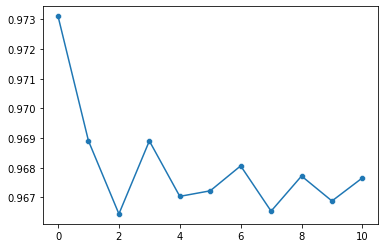

In [ ]:
sns.scatterplot(x=list(range(len(acc_lst))), y=acc_lst)
sns.lineplot(x=list(range(len(acc_lst))), y=acc_lst)